This is a IJulia notebook that generates 1D cellular automata using images to provide the rules. 

First, it posterizes the provided image using KMeans clustering. 
Then, it looks through the image and collects every three pixels that have another pixel under the middle of three pixels. If the three pixels do not already represent a rule, create a rule saying that those three pixels produce their child pixel. 
Then, generate an initially random row. 
Then, create additional rows using the row immediately above and the set of rules we got from the image. 

Scroll all the way to the bottom of this file for example output. You can modify and rerun all the code, and its written in a very fast language so it can handle pretty large images. However, this website cannot _display_ all images, so be careful what you ask it to do or you'll freeze your browser. 

In [1]:
using FileIO      #enable loading saved image files
using Clustering  #library to provide KMeans clustering
using Images      #library to allow images to be manipulated and displayed

In [100]:
#This section is responsible for posterizing images

#convert a pixel to a vector of its rgb values
function convert_pixel(pixel::Images.ColorTypes.RGB)::Vector{Float64}
    return [pixel.r, pixel.g, pixel.b]
end

#convert a vector of a vector of rgb values to a pixel
function convert_pixel(p::Array{Array{Float64,1},1})
    return RGB(p[1]...)
end

#this doesn't work but it looks cool sometimes
function neat_failed_posterize(img, n_colors::Int)
    numerical_values = map(convert_pixel, img)
    totals::Vector{Vector{Float64}} = []
    for row_i in 1:size(numerical_values)[1]
        append!(totals, numerical_values[row_i,:])
    end
    newtotals = hcat(totals...)
    
    R = kmeans(newtotals, n_colors; maxiter=200)
    
    replaced_pixels = [[R.centers[:,i]] for i in assignments(R)]
    
    width, height = size(img)
    
    posterized_img = rotr90(reshape(replaced_pixels, (width, div(length(replaced_pixels), width))))
    
    map(convert_pixel, posterized_img)
end

#posterize the passed image
function img_posterize(img, n_colors::Int)
    width, height = size(img)
    
    #first we need to convert the matrix of RGB pixels to a matrix of float64 vectors
    numerical_values = map(convert_pixel, img)
    
    #now we need to flatten the matrix, so kmeans can operate on it
    kmeans_input = hcat(numerical_values...)
    
    #now we call kmeans
    R = kmeans(kmeans_input, n_colors; maxiter=200)
    
    #now we have an array of cluster averages, and an array mapping pixels to clusters
    #first let's convert the array of centers to an array of RGB centers
    centers = [RGB(R.centers[:,i]...) for i in 1:size(R.centers)[2]]
    
    #replace assignments with centers
    posterized_vector = [centers[i] for i in assignments(R)]
    
    #now we reshape the flat vector back into a matrix
    hcat([posterized_vector[width*i+1:width*(i+1)] for i in 0:(height-1)]...)
end

#generate posterized values for img, but don't fill them in
function posterize(img, n_colors::Int)
    width, height = size(img)
    
    #first we need to convert the matrix of RGB pixels to a matrix of float64 vectors
    numerical_values = map(convert_pixel, img)
    
    #now we need to flatten the matrix, so kmeans can operate on it
    kmeans_input = hcat(numerical_values...)
    
    #now we call kmeans
    R = kmeans(kmeans_input, n_colors; maxiter=200)
    
    #now we have an array of cluster averages, and an array mapping pixels to clusters
    #first let's convert the array of centers to an array of RGB centers
    centers = [RGB(R.centers[:,i]...) for i in 1:size(R.centers)[2]]
    
    #now, we can either construct a new image using the assigned center values, 
    #or we can save the matrix of assigned values alongside the list of center values,
    #which is a lot faster. So, it's what we use in the rest of the cellular automaton code
    posterized_vector = assignments(R)
    
    #now we reshape the flat vector back into a matrix
    m = hcat([posterized_vector[width*i+1:width*(i+1)] for i in 0:(height-1)]...)
    
    return (m, assignments(R), centers)
end

posterize (generic function with 1 method)

In [4]:
#now we need to train the model
function train(img::Array{Int,2})
    height, width = size(img)
    model = Dict{Tuple{Int, Int, Int}, Int}()
    for row_i in 1:(height-1)
        for column_i in 2:(width-1)
            key = tuple(img[row_i,column_i-1:column_i+1]...)
            if !haskey(model, key)
                value = img[row_i+1, column_i]
                model[key] = value
            end
        end 
    end
    model
end 

train (generic function with 1 method)

In [5]:
#now we need to populate an image using the model

#check if the three parents are in the model. If they aren't, pick a random color. 
function get_value(model::Dict{Tuple{Int, Int, Int}, Int}, 
        key::Tuple{Int, Int, Int}, 
        possible_values::UnitRange{Int})
    if haskey(model, key)
        return model[key]
    else 
        return rand(possible_values)
    end
end

# populate and image
function fill_in(model::Dict{Tuple{Int, Int, Int}, Int}, assignments, width, height)
    #assignments is dense array of N
    possible_values = 1:max(assignments...)
    println(possible_values)
    
    image = Vector{Vector{Int}}()
    #we need to make the initial row 
    #lets just randomly populate it
    push!(image, rand(possible_values, width))
    
    #now we need to make all the other rows based on the row above it
    for i in 2:height
        this_row = Vector{Int}()
        prev_row = image[i-1]
        
        #the very first pixel will be missing the leftmost pixel
        first_key = tuple(prev_row[end], prev_row[1], prev_row[2])
        push!(this_row, get_value(model, first_key, possible_values))
        
        #now we fill in to the second to last pixel
        for j in 2:width-1
            key = tuple(prev_row[j-1:j+1]...)
            push!(this_row, get_value(model, key, possible_values))
        end
        
        #now the last pixel
        last_key = tuple(prev_row[end-1], prev_row[end], prev_row[1])
        push!(this_row, get_value(model, last_key, possible_values))
        
        #now we put this row into the image
        push!(image, this_row)
    end
    
    #we need to convert the vector of vectors to a 2d matrix
    rotr90(hcat(image...))
end

#convert a matrix of assignments to an image
function make_image(assignment_matrix, centers)
    map(x->centers[x], assignment_matrix)
end

make_image (generic function with 1 method)

In [25]:
#let's make a function to chain all the steps together for us

function download_image(url, filename)
    run(`wget $url -O $filename -q`)
end

function run_on_file(filename, n_colors, width, height)
    img = load(filename)
    posterized, assign, centers = posterize(img, n_colors)
    model = train(posterized)
    am = fill_in(model, assign, width, height)
    make_image(am, centers)
end

run_on_file (generic function with 1 method)

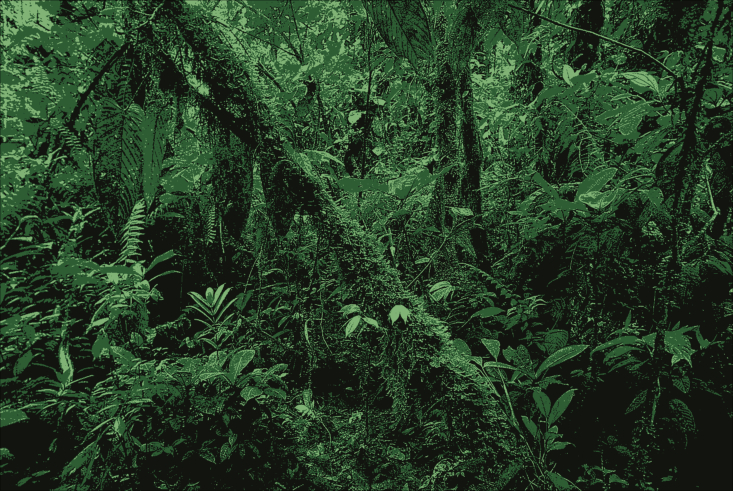

In [88]:
#now we can experiment with different images and amounts of colors
download_image(
   "https://cdn.britannica.com/90/3890-050-F451C580/rainforest-coast-lowland-rainforests-Ecuador-tropics-evergreen.jpg", 
   "jungle")

#display what we just downloaded
img_posterize(load("jungle"), 3)

1:7


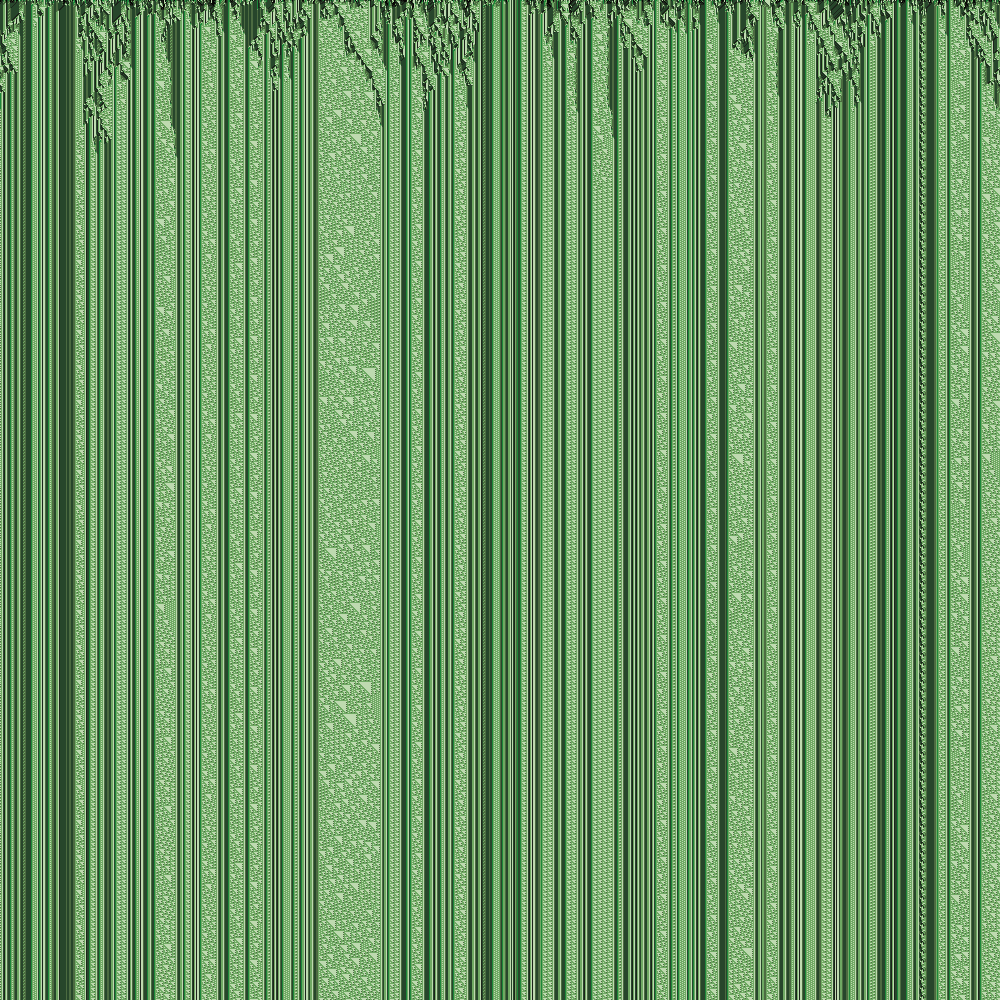

In [89]:
run_on_file("jungle", 7, 1000, 1000)

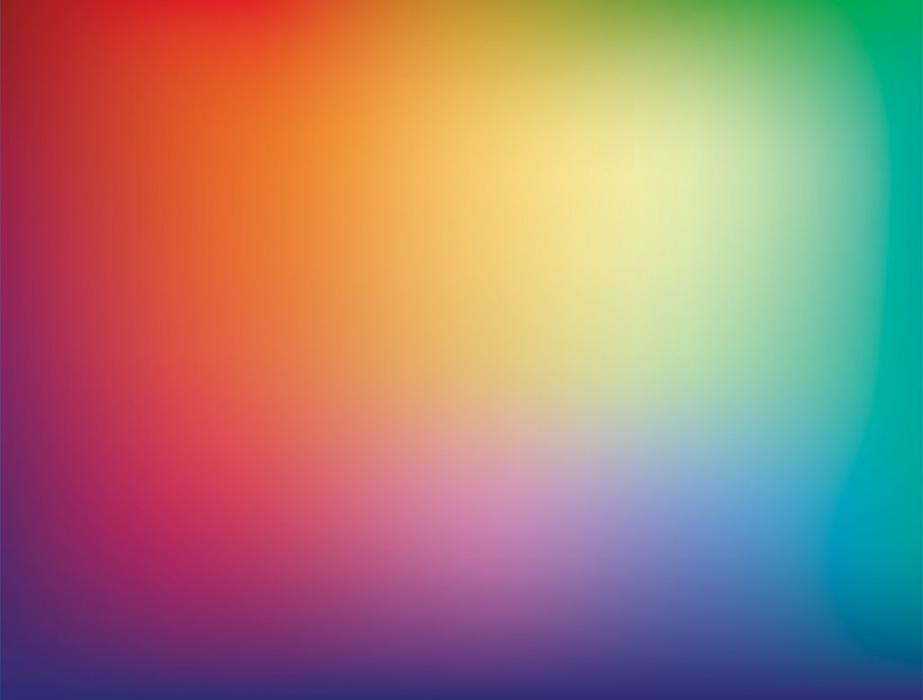

In [94]:
download_image("https://cdn.shopify.com/s/files/1/1259/9857/products/jigsaw-puzzle-blurry-rainbow-impuzzible-1000-piece-jigsaw-puzzle-1_3615f516-cd39-413f-ba45-363382364c0c_923x700.jpg?v=1565821390", 
    "rainbow")

load("rainbow")

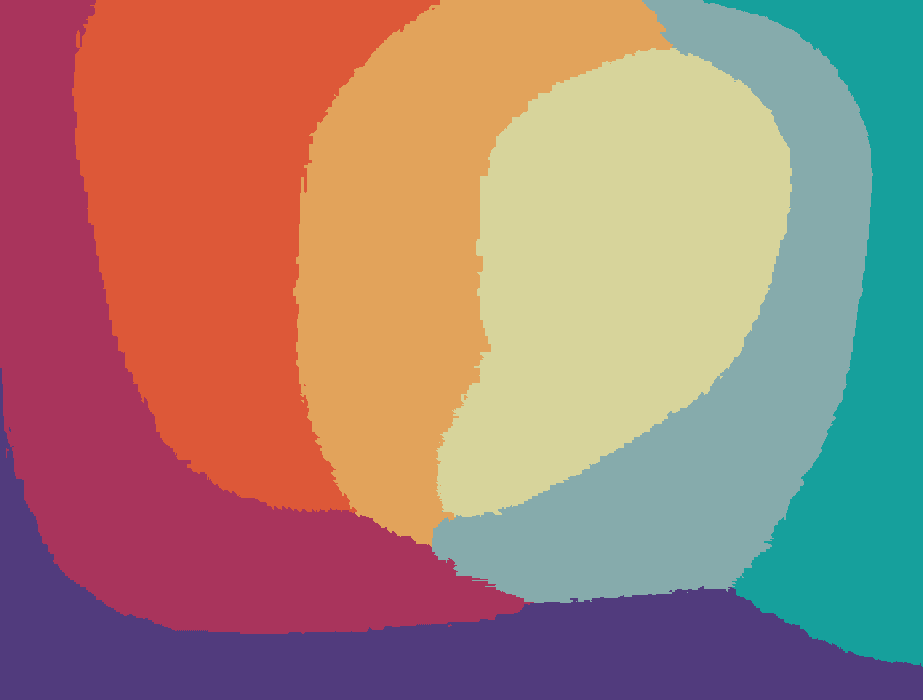

In [101]:
img_posterize(load("rainbow"), 7)

1:7


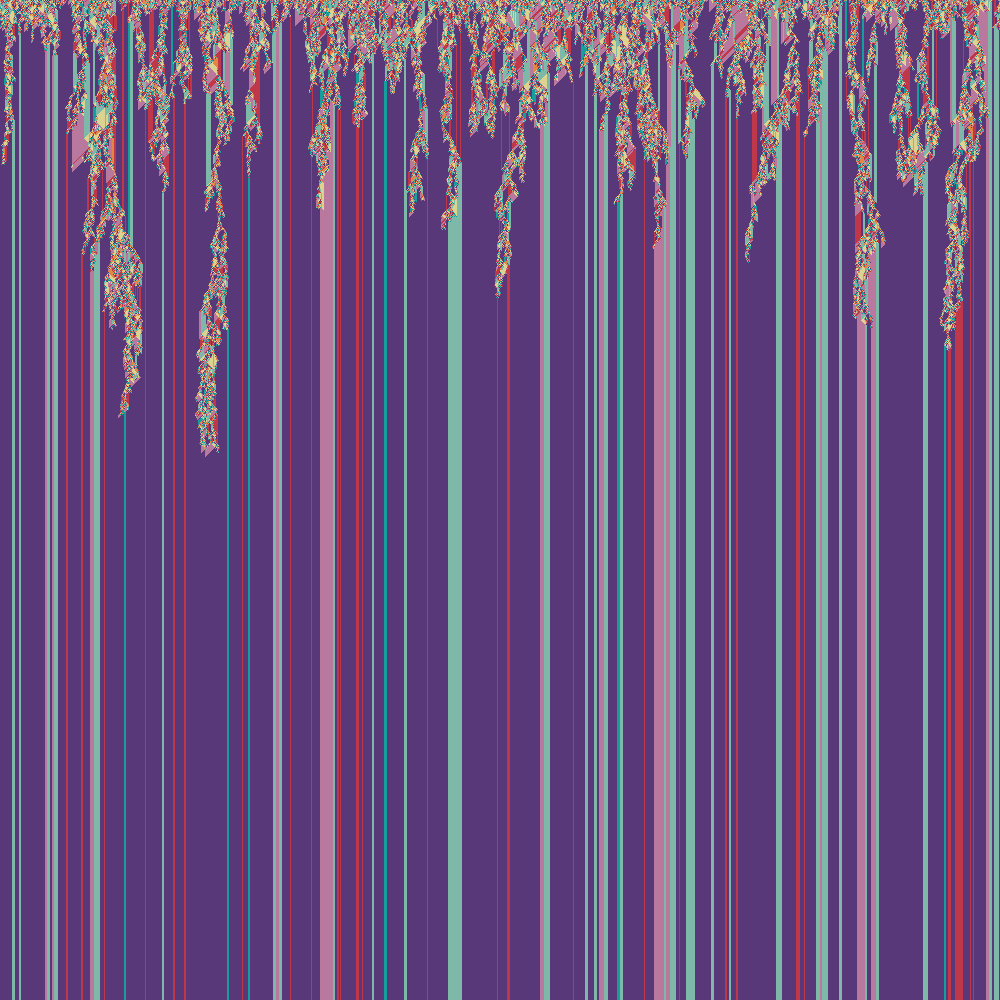

In [39]:
run_on_file("rainbow", 7, 1000, 1000)

1:8


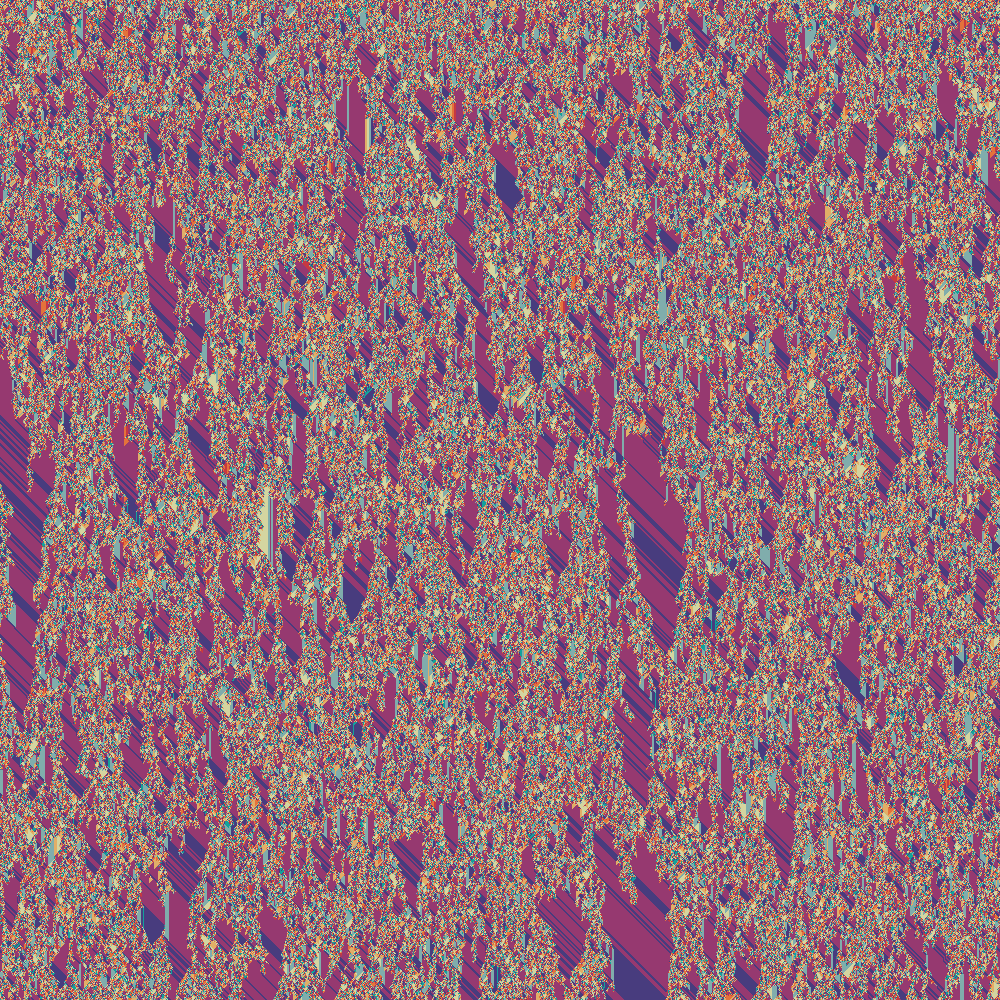

In [102]:
run_on_file("rainbow", 8, 1000, 1000)

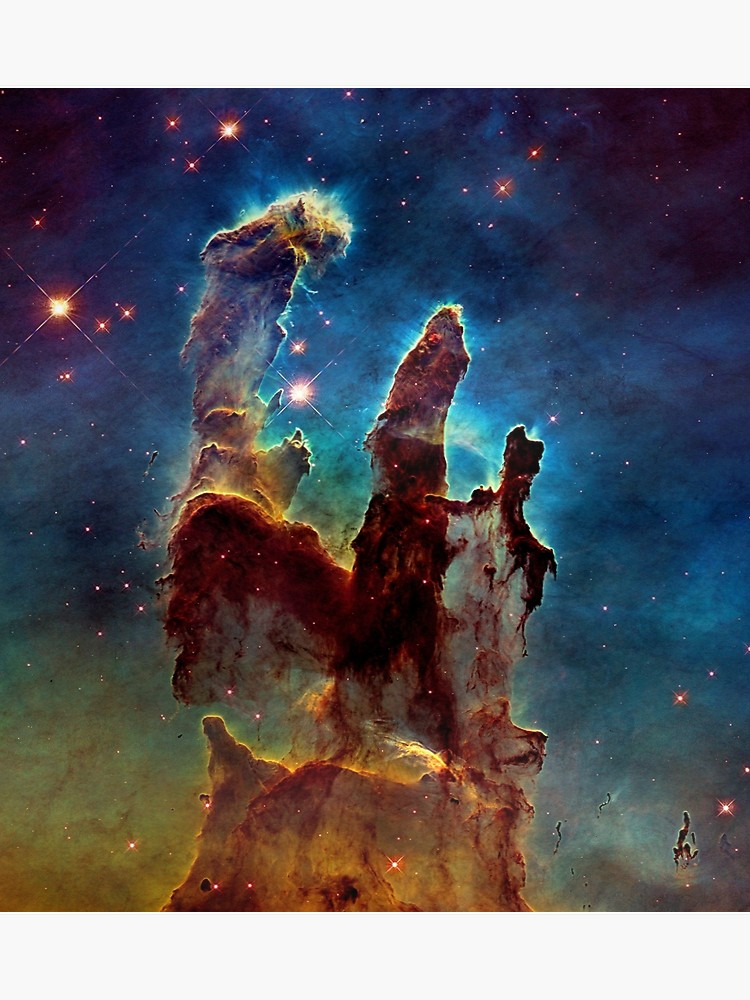

In [51]:
download_image("https://ih1.redbubble.net/image.576604602.5788/poster,840x830,f8f8f8-pad,750x1000,f8f8f8.u2.jpg", "pillars")

load("pillars")

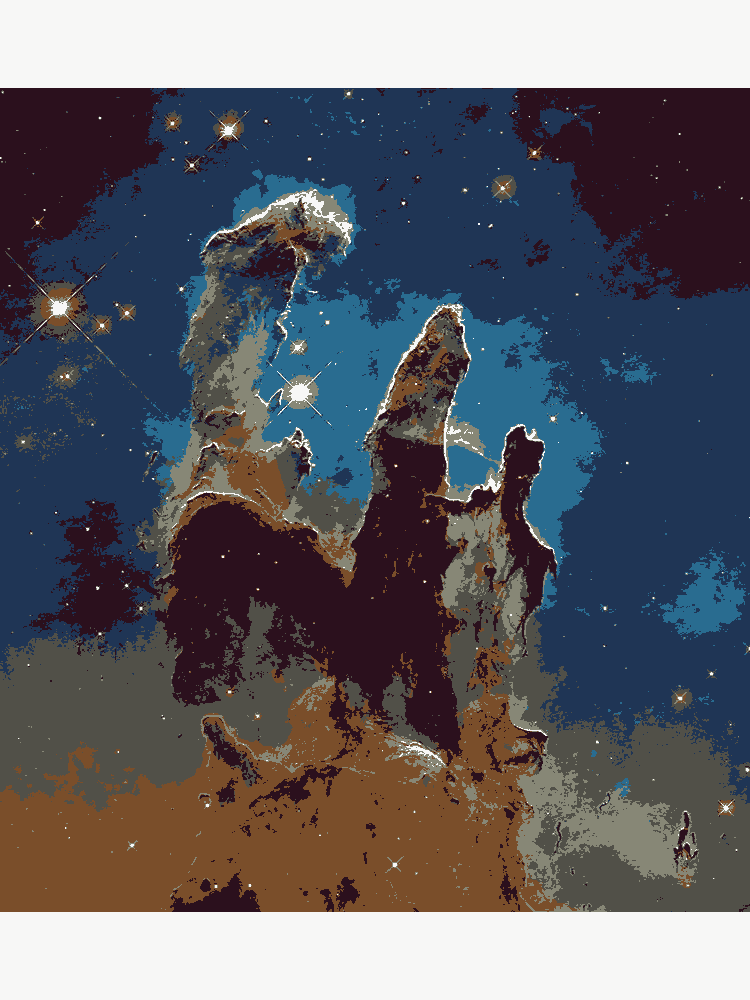

In [99]:
img_posterize(load("pillars"), 7)

1:11


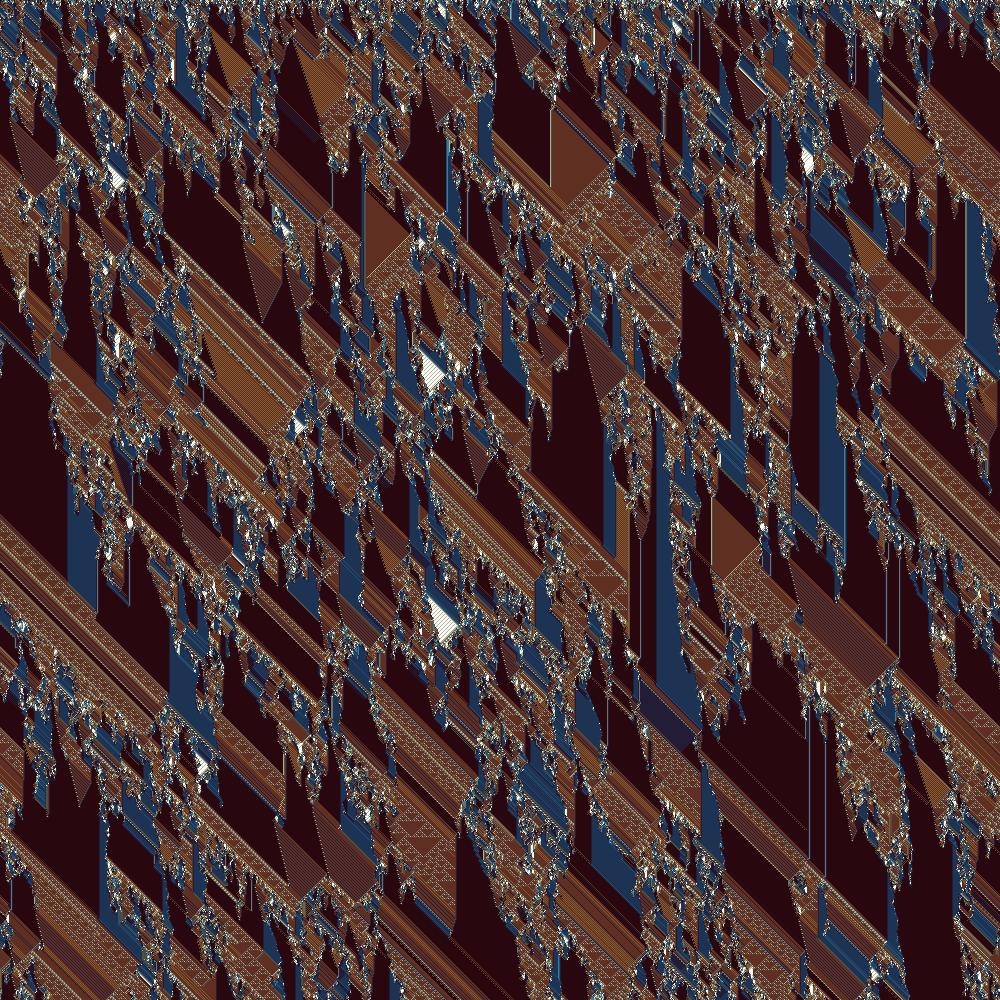

In [55]:
run_on_file("pillars", 11, 1000, 1000)

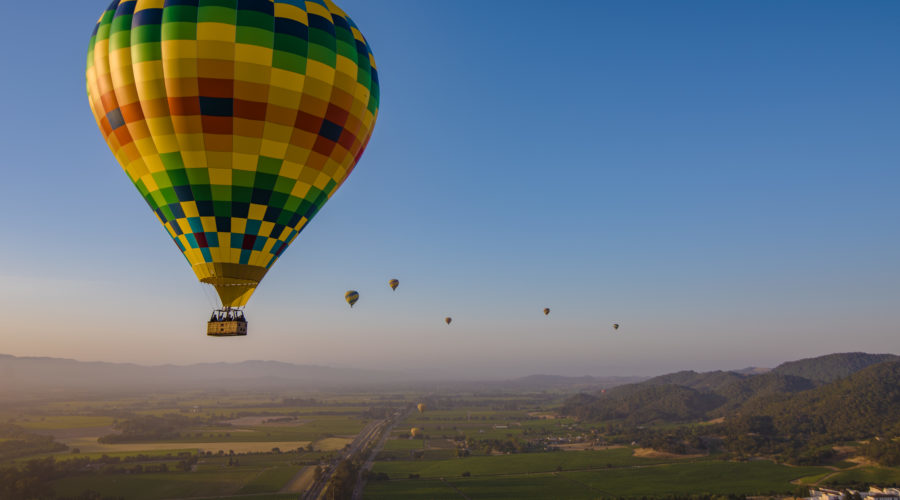

In [65]:
download_image("https://www.sunset.com/wp-content/uploads/1-napa-valley-aloft-pr-1018-900x500.jpg", "balloon")
load("balloon")

1:9


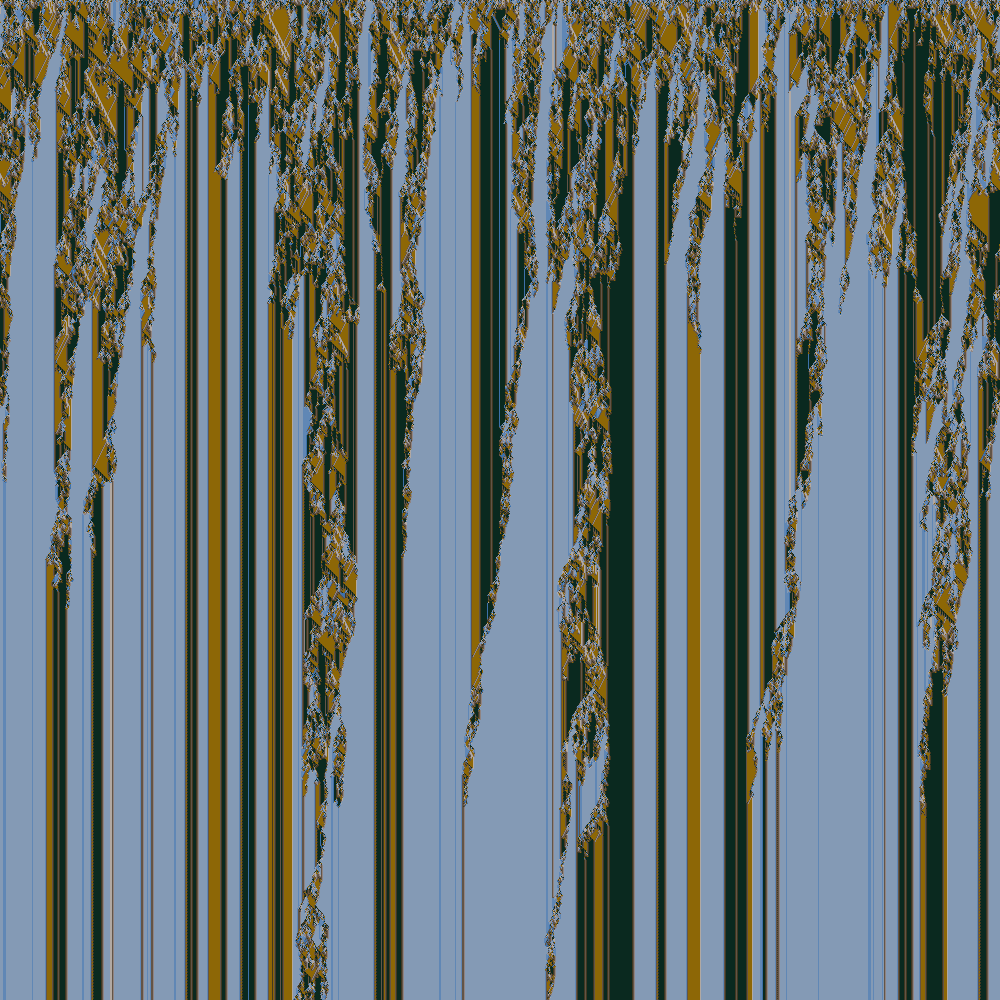

In [74]:
run_on_file("balloon", 9, 1000, 1000)